In [2]:
import stim
import numpy as np
import qiskit
import itertools
import nbimporter

from NonCliff_1Meas_V4 import *
from stab_rank_approx import *

from qiskit.quantum_info import Pauli, PauliList, StabilizerState
from typing import List, Tuple

In [3]:
def find_nearest_neighbors_general_V2(num_qubits: int, stab_state: np.array) -> List:
    """ 
    Construct list of all nearest neighbor stabilizer states for arbitrary stabilizer state.

    Parameters:
    -----------
    stab_state - Stabilizer state for which we wish to find neighbors

    Returns:
    --------
    List of nearest neighbors
    """
    bias = 1/np.sqrt(2)
    all_paulis = generate_all_paulis(num_qubits)
    new_stabs = [p.to_matrix() @ stab_state for p in all_paulis]
    new_stabs_orthogonal = [stab for stab in new_stabs if np.vdot(stab_state, stab) == 0]
    neighbors = [np.add(stab_state, stab) * bias for stab in new_stabs_orthogonal]
    neighbors_dict = {stab.tobytes(): stab for stab in neighbors}
    # return list(neighbors_dict.values())
    final_neighbors = list(neighbors_dict.values())
    final_neighbors.append(stab_state)
    return final_neighbors

In [4]:
def is_orthogonal(used_states: List, curr_stab: np.array):
    """
    Checks that all the stabilizer states that are being used for decomposition are indeed orthogonal

    Params:
    -------
    used_states - stabilizer states used so far 
    curr_stab - Next stabilizer state to be used for decomposition
    """ 
    if (np.array_equal(curr_stab, None)):
        return False
    for elem in used_states:
        if (np.vdot(curr_stab, elem) != 0):
            return False 
    return True 

def iterated_optimal_nearest_neighbor_V2(num_qubits:int, eig_vec:np.array, init_stab_state: np.array, used_states: List) -> np.array:
    """ 
    Iteratively compute the optimal nearest neighbor whose inner product with 'eig_vec' is maximal

    Parameters:
    -----------
    num_qubits - Number of qubits
    eig_vec - Eigenvector we wish to approximate
    init_stab_state - Initial stabilizer state where we start our search from 

    Returns:
    --------
    Optimal single state that best approximates 'eig_vec'
    """
    num_iterations = 2 ** num_qubits
    curr_stab_state = init_stab_state
    max_inner_prod = 0
    curr_best_stab_state = None
    for _ in range(num_iterations):
        curr_neighbors = find_nearest_neighbors_general_V2(num_qubits, curr_stab_state)
        if (used_states != []):
            cp = []
            for neighbor in curr_neighbors:
                for state in used_states:
                    if (np.vdot(neighbor, state) == 0):
                        cp.append(neighbor)
            curr_neighbors = cp
        optimal_neighbor = curr_neighbors[np.argmax([np.abs(np.vdot(neighbor, eig_vec)) for neighbor in curr_neighbors])]
        curr_stab_state = optimal_neighbor 
        #curr_inner_prod = np.vdot(curr_stab_state, eig_vec)
        curr_inner_prod = np.abs(np.vdot(curr_stab_state, eig_vec))
        if (np.array_equal(curr_best_stab_state,curr_stab_state)):
            break
        if (curr_inner_prod > max_inner_prod):
            max_inner_prod = curr_inner_prod 
            curr_best_stab_state = curr_stab_state

    return curr_best_stab_state, max_inner_prod

In [5]:
def one_state_stab_approx_V2(num_qubits:int, eig_vec: np.array, used_states: List) -> np.array:
    """ 
    Find best (?) single stabilizer state approximation for eigen vector 

    Parameters:
    -----------
    num_qubits - Number of qubits
    eig_vec - Eigenvector we wish to approximate

    Returns:
    --------
    Best (?) single stabilizer state that approximates eigenvector
    """

    basis_vecs = comp_base_vecs(num_qubits) # Basis vectors given number of qubits
    init_state = eig_vec.copy() # Make a copy of the original eigenvector
    #final_approx_state = np.zeros((2**num_qubits,), dtype=complex) # Where result for best stab state approx is stored
    
    # Find basis state with maximum coefficient
    max_coeff = state_max_coeff(eig_vec, basis_vecs)
    init_stab_state = basis_vecs[max_coeff]

    # Compute optimal nearest stab state in iterated fashion
    final_approx_state, max_inner_prod = iterated_optimal_nearest_neighbor_V2(num_qubits, eig_vec, init_stab_state, used_states)

    return final_approx_state, max_inner_prod

Will need to try a Brute-Force approach to search all possible stabilizer states to find the optimal stabilizer rank decomposition:
FIRST LOOK AT SPARSIFICATION LEMMA

In [6]:
def stab_rank_approx_four_V2(num_qubits: int, eig_vec: np.array) -> Tuple:
    """ 
    Approximate the stabilizer rank (using approach discussed)

    Parameters:
    -----------
    num_qubits - Number of qubits
    eig_vec - Eigenvector for which we'd like to evaluate stabilizer rank

    Returns:
    --------
    Approximate stabilizer rank for eigenvector
    """
    approx_stab_rank = 0 
    approx_vec = np.zeros(len(min_eigvec), dtype=complex) # Vector we wish to construct to approximate 'eig_vec'
    prec_param = 0.02 # Precision parameter to see how close dot prod of 'approx_vec' and 'eig_vec' is
    used_states = []
    norm_factor = 0
    last_inner = 0
    is_approx = False # While loop termination condition

    copy_vec = eig_vec.copy()
    while (is_approx == False):
        # Calculate nearest stabilizer state
        s, s_inner_prod = one_state_stab_approx_V2(num_qubits, eig_vec, used_states)
        #print("Is orthogonal?: " + str(is_orthogonal(used_states, s)))
        used_states.append(s)
        #print("Stab: " + str(list(s)))

        # Project 'eig_vec' on s
        s_norm = np.linalg.norm(s)
        s_coeff = np.vdot(s, eig_vec)
        if (norm_factor == 0):
            proj_vec = (s_coeff) * s
        else:
            proj_vec = norm_factor * (s_coeff) * s

        # Subtract projection of 'eig_vec' on s from 'eig_vec'
        unnorm_eig_vec = eig_vec - proj_vec 
        norm_factor = np.linalg.norm(unnorm_eig_vec)
        #eig_vec = unnorm_eig_vec / norm_factor
        eig_vec = unnorm_eig_vec

        # Add projection to approximation and update stab rank
        approx_vec += proj_vec
        approx_stab_rank += 1

        # Check closeness of approximation to original 'eig_vec'

        """ 
        if (last_inner > np.vdot(approx_vec / np.linalg.norm(approx_vec), copy_vec)):
            approx_vec -= proj_vec
            approx_stab_rank -= 1
            break
        """

        #last_inner = np.vdot(approx_vec / np.linalg.norm(approx_vec), copy_vec)
        last_inner = np.vdot(approx_vec, copy_vec)
        print("How close: " + str(last_inner))
        if (np.abs(1 - np.vdot(approx_vec, copy_vec)) <= prec_param):
            is_approx = True 
        #print(np.linalg.norm((approx_vec / np.linalg.norm(approx_vec)) - copy_vec))
        #if (np.linalg.norm((approx_vec / np.linalg.norm(approx_vec)) - copy_vec) <= prec_param):
        #    is_approx = True

        if (approx_stab_rank == 2 ** num_qubits):
            break

        #print("Approx vec so far: " + str(list(approx_vec)))
        
    approx_vec = approx_vec / np.linalg.norm(approx_vec)
    
    return approx_stab_rank, approx_vec


In [7]:
num_wit_qubits = 20 # variable 'n' in paper
# For now, what the witness qubits are initialized to be doesn't matter (I THINK)
# as we are trying to minimize Val, given some optimal input states.
wit_qubits = np.zeros(num_wit_qubits, dtype=complex)

num_anc_qubits = 0 # variable 'm' in paper
anc_qubits = np.zeros(num_anc_qubits, dtype=complex)

num_t_gates = 4 # variable 't' in paper

num_meas_qubits = 1 # variable 'k' in paper
total_qubits = num_wit_qubits + num_anc_qubits

num_layers = 100

assert(num_layers > 0)

In [13]:
p_sum, _ = sim_circ(total_qubits, num_layers, num_t_gates)
succinct_p_sum, succinct_basis = p_sum.succinct_p_sum(total_qubits)
succinct_p_sum.set_bases(succinct_basis)
min_eigvec = succinct_p_sum.compute_min_eig_eigvec(len(p_sum.get_bases()))[1]
new_total_qubits = len(succinct_p_sum.get_sum()[0].get_pauli_str(succinct_p_sum.get_sum()[0].get_pauli()))
print(succinct_p_sum)
print(list(min_eigvec))

[(-0.4999999999999999+0j) ZIII] + [(0.3535533905932737+0j) YZII] + [(0.4999999999999999-0j) XIZI] + [(-0.4999999999999999+0j) XXXZ] + [(-0.3535533905932737+0j) IYXZ]
[(-0.012062168986335763+0.0010999624854878725j), (-0.09656719686509034-0.0019818963392177827j), (-0.29406492648397486+0.03667131155998507j), (-0.19585222759597326+0.027613564587386716j), (0.5332327133033258+0j), (-0.09253898841924638+0.12181986885053805j), (0.08033964232535329+0.0858399453097737j), (-0.3343087020363136+0.3965486309284023j), (0.044845226618014655+0.03228802131595409j), (0.13809107910098523-0.15826272829145624j), (0.12798139405011727+0.15515383726011855j), (-0.011697366221551892+0.03245410023471585j), (-0.31233599008034824+0.16807343022860485j), (0.07506669167367457-0.0688656975653452j), (-0.005083870969937544+0.05848632584235541j), (-0.2100174598516369+0.021497812864798474j)]


In [14]:
approx_stab_rank, approx_vec = stab_rank_approx_four_V2(new_total_qubits, min_eigvec)
print(approx_stab_rank, approx_vec)

How close: (0.5688360608079408+2.7755575615628914e-17j)
How close: (0.6495434290128861+5.551115123125783e-17j)
How close: (0.735547984138456+5.551115123125783e-17j)
How close: (0.7923930274829205+0.006636773260483592j)
How close: (0.8082935619115859+0.0018662231183999012j)
How close: (0.8454912634862682+0.006414418159361224j)
How close: (0.8705617589718964+0.006931213998919161j)
How close: (0.8830636376143519+0.0034365647424189905j)
How close: (0.8883291744558235+0.006182101572639126j)
How close: (0.8956685872310894+0.0071409230139799496j)
How close: (0.9027370018747096+0.005947825575910615j)
How close: (0.908376716291424+0.005165442022717959j)
How close: (0.9116451707998129+0.0067223648421718685j)
How close: (0.9155407553157618+0.006145383356707945j)
How close: (0.9211163236577276+0.008979074872616982j)
How close: (0.9224653020850029+0.008275901175048977j)
16 [-0.03909149+0.0020413j  -0.07526484-0.0130736j  -0.27671497+0.03283318j
 -0.18037661+0.01257028j  0.53165597-0.02082297j -0.07

In [13]:
num_iter = 50
stab_rank_avg = 0
num_t_gates = 6
t_gate_cap = 11
stab_rank_list = []
for _ in range(t_gate_cap):
    stab_rank_avg = 0
    for i in range(num_iter):
        print(i)
        p_sum, _ = sim_circ(total_qubits, num_layers, num_t_gates)
        succinct_p_sum, succinct_basis = p_sum.succinct_p_sum(total_qubits)
        succinct_p_sum.set_bases(succinct_basis)
        min_eigvec = succinct_p_sum.compute_min_eig_eigvec(len(p_sum.get_bases()))[1]
        new_total_qubits = len(succinct_p_sum.get_sum()[0].get_pauli_str(succinct_p_sum.get_sum()[0].get_pauli()))
        approx_stab_rank, _ = stab_rank_approx_four_V2(new_total_qubits, min_eigvec)
        stab_rank_avg += approx_stab_rank
    stab_rank_avg = stab_rank_avg / num_iter
    print(stab_rank_avg)
    stab_rank_list.append((num_t_gates, stab_rank_avg))
    num_t_gates += 1

0
{'-XZYXXZ_XYXYYZZ_YXZZX': GF([[1]], order=2)}
How close: (1+0j)
1
{'-_ZXXZXYXXYXXYXZXXYZZ': GF([[0],
    [1],
    [1],
    [0],
    [0],
    [0]], order=2), '-__XXZXX_XXY__XZX__YX': GF([[0],
    [0],
    [0],
    [0],
    [0],
    [0]], order=2), '+_X_YYXYXXZ_X_X_YXYZ_': GF([[0],
    [0],
    [0],
    [1],
    [0],
    [0]], order=2), '+_Y_YYXX_X_Z_YX_Y__YY': GF([[0],
    [1],
    [1],
    [1],
    [0],
    [0]], order=2), '-ZY_Z__XY_XZXXZYYXX__': GF([[0],
    [0],
    [1],
    [1],
    [0],
    [0]], order=2), '-ZZX_X_YZ_ZX_XZXX_ZXX': GF([[0],
    [0],
    [1],
    [0],
    [0],
    [0]], order=2), '-ZZZ_Y__XYXY___XXYXY_': GF([[0],
    [0],
    [1],
    [0],
    [0],
    [0]], order=2), '-Z_Z_Y_Z_YYXXY_XXZZZY': GF([[0],
    [1],
    [0],
    [0],
    [0],
    [0]], order=2), '-__ZX_XZYZZX_XYZXYYX_': GF([[0],
    [0],
    [0],
    [0],
    [0],
    [0]], order=2), '+YXZYXXZ_ZX_YYX_XZZY_': GF([[0],
    [0],
    [0],
    [0],
    [0],
    [0]], order=2), '-Y_YX_X_XZZYZYXZYYXZX': GF([[0

KeyboardInterrupt: 

In [376]:
print(stab_rank_list)

[(0, 1.0), (1, 1.53), (2, 2.66), (3, 5.07), (4, 10.87)]


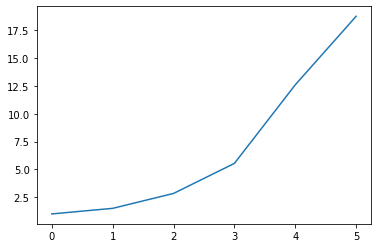

In [382]:
%matplotlib inline 
import matplotlib.pyplot as plt
x = [s[0] for s in stab_rank_list]
y = [s[1] for s in stab_rank_list]
plt.xticks(x)
plt.plot(x,y)
plt.show()